<a href="https://colab.research.google.com/github/Aurelien-le-camus/Forcasting/blob/main/Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Seasonal Time Series Analysis

---
> D22125166 Alexandre BOUL

> D22125080 Aurélien Le Camus
---


### **Summary**
*   Dataset source : https://www.kaggle.com/datasets/kandij/electric-production
*   1- Goal of the project 
*   2- Data preprocessing
*   3- Test ADF
*   4- Checking stationnarity
*   5- The ARIMA Model
*   6- Forecasting
*   Conclusion
-------------------------------------------------------------------------


##Seasonal data

>The data set used is about the purcentage of electricity consumption of monthly production of electricity beetween 2000 and 2005.
We can observe that there is a pattern that repeats during the same period each year. There is a significant increase in electricity consumption during the winter period, and consumption is at its lowest throughout the summer.


>https://www.kaggle.com/datasets/kandij/electric-production


# Data processing

---

>The goal of our forcasting is to study the evolution of electricity consumption of the monthly production of electricity. Our goal is also to identify a potential trend in the evolution over the years to make analyzes for the future and our consumption

In [2]:
#Import the required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

warnings.filterwarnings('ignore')

In [3]:
#Data loading in a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/Aurelien-le-camus/Forcasting/main/electricity_consumption.csv', sep=',', usecols = ['DATE', 'Value'])
#Dhow top records in the df
df.head()

,DATE,Value
0,01-01-2000,102.2301
1,02-01-2000,94.2989
2,03-01-2000,88.0927
3,04-01-2000,81.4425
4,05-01-2000,84.4552


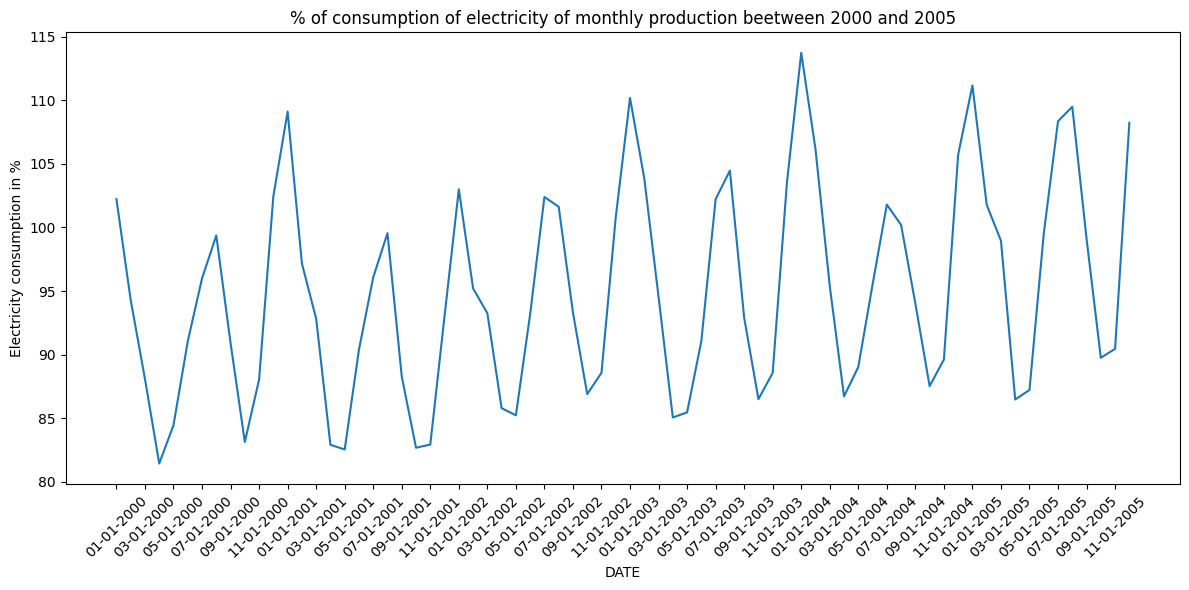

In [4]:
fig, ax = plt.subplots()

dates = [datetime.strptime(date, '%d-%m-%Y') for date in df['DATE']]

# Plot the data on the axis
ax.plot( df['DATE'], df['Value'])

# Add labels and a title
ax.set_xlabel('DATE')
ax.set_ylabel('Electricity consumption in %')
ax.set_title('% of consumption of electricity of monthly production beetween 2000 and 2005')

# Enlarge the figure and make all the ticks readable for a better analysis
fig.set_size_inches(12, 6)
ticks = ax.get_xticks()

# Adding style to the text to make the ticks clearer
plt.xticks(ticks[::2])
plt.xticks(rotation=45)

# Show the figure
plt.tight_layout()
plt.show()

# Test ADF

In [5]:
ADF_result = adfuller(df['Value'])

# Print the result of the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')
# Extract the critical values at different significance levels
critical_values = ADF_result[4]
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

ADF Statistic: 0.06809102618419358
p-value: 0.9638137721366177
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


> This results in an ADF statistic of 0.06 and a p-value of 0.96. Here, the ADF statistic is not a small negative number, and the p-value is larger than 0.05. Therefore, our time series is not stationary, and we must apply transformations to make it stationary.

## Checking stationnarity



ADF Statistic: -3.330525249899997
p-value: 0.013567926654347993
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


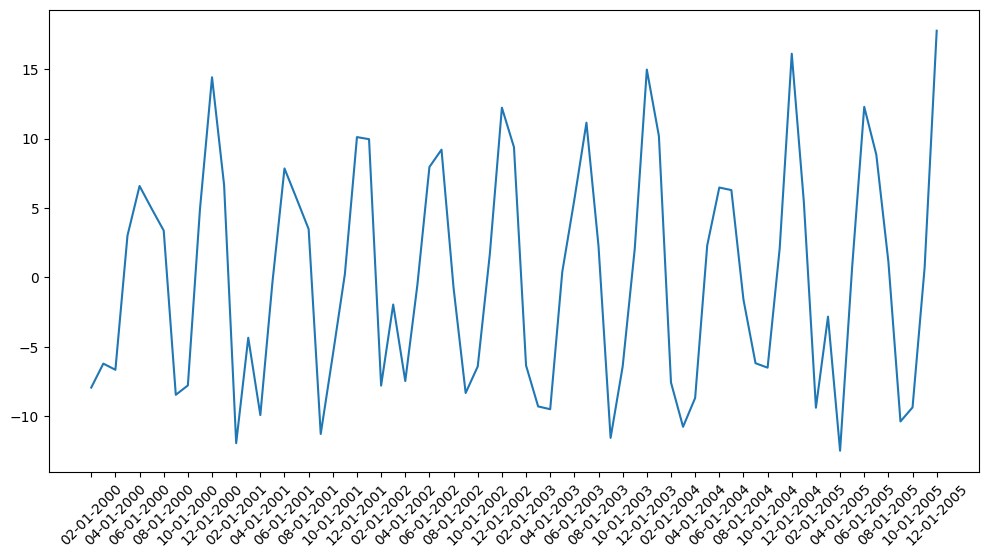

In [39]:
# Create figure and axes
fig, ax = plt.subplots()

# Calculate the difference between consecutive values in the 'Value' column of the 'df' DataFrame using np.diff
value_diff = np.diff(df['Value'], n=1)

# Create a new array of dates from the first column named 'DATE' in the DataFrame 'df'
new_date_array = df['DATE'].values

# Remove the first value from 'new_date_array'
new_date_array = new_date_array[1:]


# Perform the Augmented Dickey-Fuller (ADF) test on the 'value_diff' array with adfuller() imported from statsmodels library
ADF_result = adfuller(value_diff)

# Print the statistical result of the new ADF test
print(f'ADF Statistic: {ADF_result[0]}')

# Print the p-value obtained from the new ADF test
print(f'p-value: {ADF_result[1]}')

# Extract the critical values at different significance levels
critical_values = ADF_result[4]
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

# Plot the data
fig.set_size_inches(12, 6)
ax.plot(new_date_array, value_diff)

ticks = ax.get_xticks()

# Adding style to the text to make the ticks clearer
plt.xticks(ticks[::2])
plt.xticks(rotation=45)

# Display the plot
plt.show()


> This results in an ADF statistic of -3.3305 and a p-value of 0.0135. Here, the ADF statistic is a small negative number, and the p-value is lower than 0.05. Therefore, our time series is stationary, and we don't need to apply more transformations.


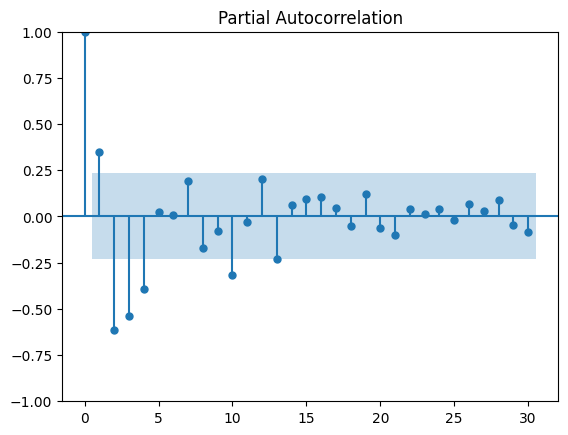

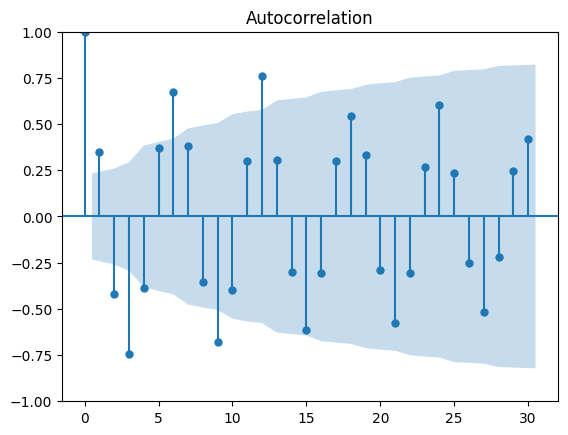

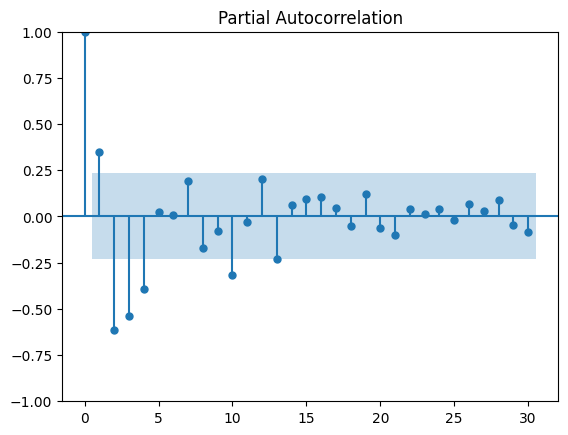

In [41]:
# Plot the autocorrelation function (ACF) of the 'value_diff' array up to 30 lags using the plot_acf() from statsmodels library
plot_acf(value_diff, lags=30)

# Plot the partial autocorrelation function (PACF) of the 'value_diff' array up to 30 lags using the plot_pacf() from the statsmodels library
plot_pacf(value_diff, lags=30, method='ywm')

> On first place, we can observe on our ACF plot that we have a sinusoidal pattern, with negative coefficients and significant autocorrelation at large lags, this is a hint that an autoregressive process is at play. We can also see the autocorrelation on our PACF plot after lag 5 and we must use an AR(5) model to produce our forecast.


##The ARIMA model
---

>In this part, we will try to find the best model that fits for our dataSet for
the last forcasting part. We will compares naive_seasonal prediction, ARIMAL prediction and SARIMA prediction models.

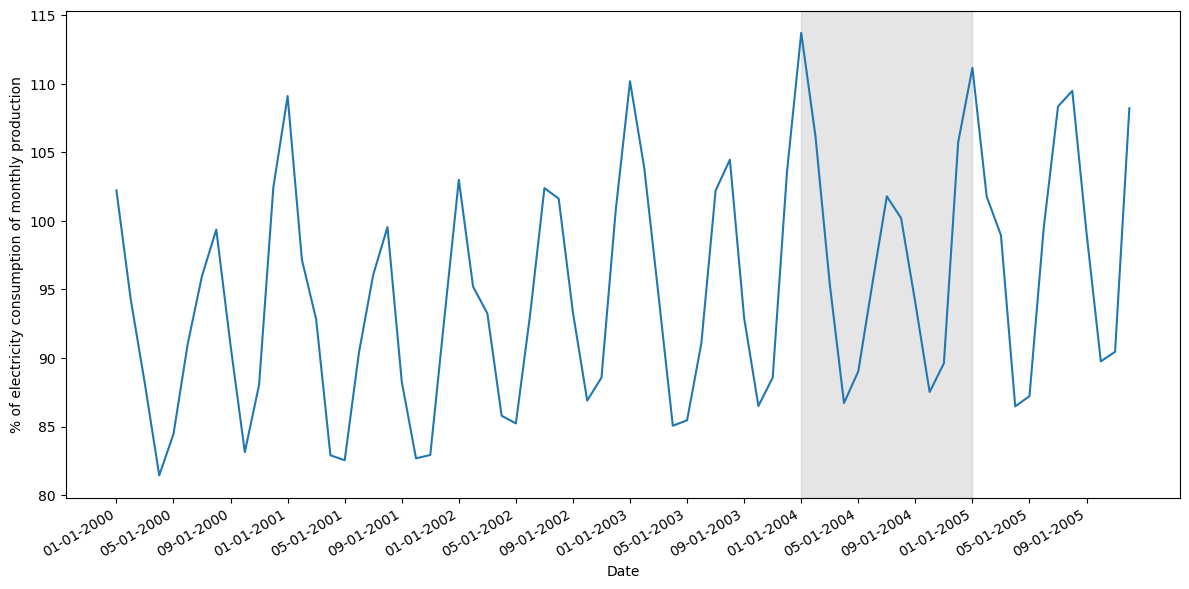

In [8]:
# Create a new figure and set its axis

fig, ax = plt.subplots()
# Plot the original data

ax.plot(df['DATE'], df['Value'])
# Set the axis labels

ax.set_xlabel('Date')
ax.set_ylabel('% of electricity consumption of monthly production')
# Add a vertical shaded region to indicate the testing period

ax.axvspan(48, 60, color='#808080', alpha=0.2)
# Get the current tick locations

ticks = ax.get_xticks()
# Set the figure size

fig.set_size_inches(12, 6)
# Add some style to the x-tick labels to make them clearer

plt.xticks(ticks[::4])
plt.xticks(rotation=45)
# Rotate the x-axis labels for better readability

fig.autofmt_xdate()
# Adjust the layout of the plot

plt.tight_layout()

Here is an example of a trend in our dataSet. We hightlight it to understand how our trend works and how our predictions will look like. Also, we only display dates every 4 month to define clear cycles relied to seasons

In [9]:
def optimize_ARIMA(train, order_list, d) -> pd.DataFrame:
    
    # create an empty list to store the results
    results = []
    
    # iterate through each order in the order_list using tqdm_notebook for a progress bar
    for order in tqdm_notebook(order_list):
        
        # try to fit an ARIMA model using SARIMAX with the current order values
        try: 
            model = SARIMAX(train, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            print('Error during optimization for ARIMA')
            # if the model fails to fit, continue with the next iteration
            continue
            
        # calculate the AIC value for the fitted model
        aic = model.aic
        
        # append the order values and AIC value to the results list
        results.append([order, aic])
        
    # create a pandas DataFrame with the results list
    result_df = pd.DataFrame(results)
    
    # name the columns of the DataFrame
    result_df.columns = ['(p,q)', 'AIC']
    
    # sort the DataFrame in ascending order of AIC value and reset the index
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    # return the sorted DataFrame
    return result_df

In [10]:
def optimize_SARIMA(train, order_list, d, D, s) -> pd.DataFrame:
    
    # create an empty list to store the results
    results = []
    
    # iterate through each order in the order_list using tqdm_notebook for a progress bar
    for order in tqdm_notebook(order_list):
        
        # try to fit a seasonal ARIMA model using SARIMAX with the current order values
        try: 
            model = SARIMAX(
                train, 
                order=(order[0], d, order[1]),  # non-seasonal order (p,d,q)
                seasonal_order=(order[2], D, order[3], s),  # seasonal order (P,D,Q,s)
                simple_differencing=False).fit(disp=False)
        except:
            print('Error during optimization for SARIMA')
            # if the model fails to fit, continue with the next iteration
            continue
            
        # calculate the AIC value for the fitted model
        aic = model.aic
        
        # append the order values and AIC value to the results list
        results.append([order, aic])
        
    # create a pandas DataFrame with the results list
    result_df = pd.DataFrame(results)
    
    # name the columns of the DataFrame
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    # sort the DataFrame in ascending order of AIC value and reset the index
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    # return the sorted DataFrame
    return result_df

In [11]:
# define the range of p and q values for the non-seasonal part of the model
ps = range(0, 13, 1)
qs = range(0, 13, 1)

# set the seasonal P and Q values to 0, since we are not considering them in this step
Ps = [0]
Qs = [0]

# set the values for the order of differencing and the seasonal period
d = 2
D = 0
s = 12

# create a list of all possible combinations of p, q, P, and Q values using the product function from itertools
ARIMA_order_list = list(product(ps, qs, Ps, Qs))

# select the training data from the 'Value' column of the input DataFrame, excluding the last 12 months (assuming monthly data)
train = df['Value'][:-12]

# call the optimize_SARIMA function to find the best model parameters based on AIC value
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)


  0%|          | 0/169 [00:00<?, ?it/s]

Error during optimization for SARIMA


In this part of the code, we are trying to find the best parameters for a non-seasonal ARIMA model using the AIC (Akaike Information Criterion) value. We define a range of values for the ARIMA model's order, then use the itertools.product function to generate all possible combinations of these values. We then select the training data and call a function called optimize_SARIMA, which tries each combination of ARIMA parameters on the training data and selects the combination with the lowest AIC value as the best model.

In [12]:
# define the range of p, q, P, and Q values for the seasonal part of the model
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

# create a list of all possible combinations of p, q, P, and Q values using the product function from itertools
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

# select the training data from the 'Value' column of the input DataFrame, excluding the last 12 months (assuming monthly data)
train= df['Value'][:-12]

# set the values for the order of differencing and the seasonal period
d = 1
D = 1
s = 12

# call the optimize_SARIMA function to find the best model parameters based on AIC value
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)


  0%|          | 0/256 [00:00<?, ?it/s]

We then define the range of values for the seasonal part of the SARIMA model, which includes the seasonal values of p, q, P, and Q. We then create a list of all possible combinations of these values using the product function from itertools. Next, we select the training data from the 'Value' column of the input DataFrame, excluding the last 12 months, and set the values for the order of differencing and the seasonal period. Finally, we call the optimize_SARIMA function to find the best model parameters based on the AIC value.

In [13]:
# defining an ARIMA model with (p,d,q) = (11,2,3) and no simple differencing

ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
# fitting the ARIMA model to the training data

ARIMA_model_fit = ARIMA_model.fit(disp=False)
# printing the summary of the ARIMA model fit

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   60
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -139.977
Date:                Mon, 08 May 2023   AIC                            309.954
Time:                        21:58:16   BIC                            340.861
Sample:                             0   HQIC                           321.993
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5641      0.212     -2.663      0.008      -0.979      -0.149
ar.L2         -0.9064      0.183     -4.955      0.000      -1.265      -0.548
ar.L3         -0.6128      0.195     -3.136      0.0

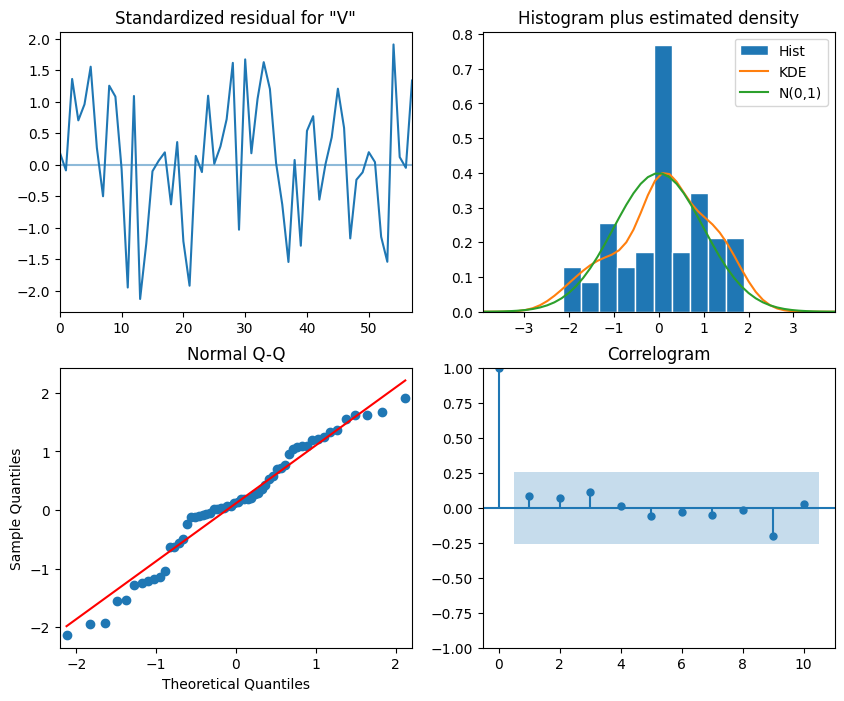

In [14]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [15]:
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

In [16]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Value'].iloc[48:60].values
test

,DATE,Value,naive_seasonal
60,01-01-2005,111.1614,113.7226
61,02-01-2005,101.7795,106.1590
62,03-01-2005,98.9565,95.4029
63,04-01-2005,86.4776,86.7233
64,05-01-2005,87.2234,89.0302
65,06-01-2005,99.5076,95.5045
66,07-01-2005,108.3501,101.7948
67,08-01-2005,109.4862,100.2025
68,09-01-2005,99.1155,94.0240
69,10-01-2005,89.7567,87.5262


In [17]:
ARIMA_pred = ARIMA_model_fit.get_prediction(60, 72).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,DATE,Value,naive_seasonal,ARIMA_pred
60,01-01-2005,111.1614,113.7226,114.451032
61,02-01-2005,101.7795,106.1590,109.283391
62,03-01-2005,98.9565,95.4029,97.553299
63,04-01-2005,86.4776,86.7233,90.514668
64,05-01-2005,87.2234,89.0302,93.158295
65,06-01-2005,99.5076,95.5045,99.677510
66,07-01-2005,108.3501,101.7948,105.653165
67,08-01-2005,109.4862,100.2025,103.092705
68,09-01-2005,99.1155,94.0240,95.193395
69,10-01-2005,89.7567,87.5262,88.287508


In [18]:
# SARIMAX model with order (2,1,1) and seasonal order (1,1,2,12)

SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
# Fit the SARIMAX model to the training data

SARIMA_model_fit = SARIMA_model.fit(disp=False)
# Print the summary of the SARIMAX model fit

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   Value   No. Observations:                   60
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -107.612
Date:                                 Mon, 08 May 2023   AIC                            229.224
Time:                                         21:58:19   BIC                            242.175
Sample:                                              0   HQIC                           234.097
                                                  - 60                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7117      0.243      2.934      0.003       0.236       1

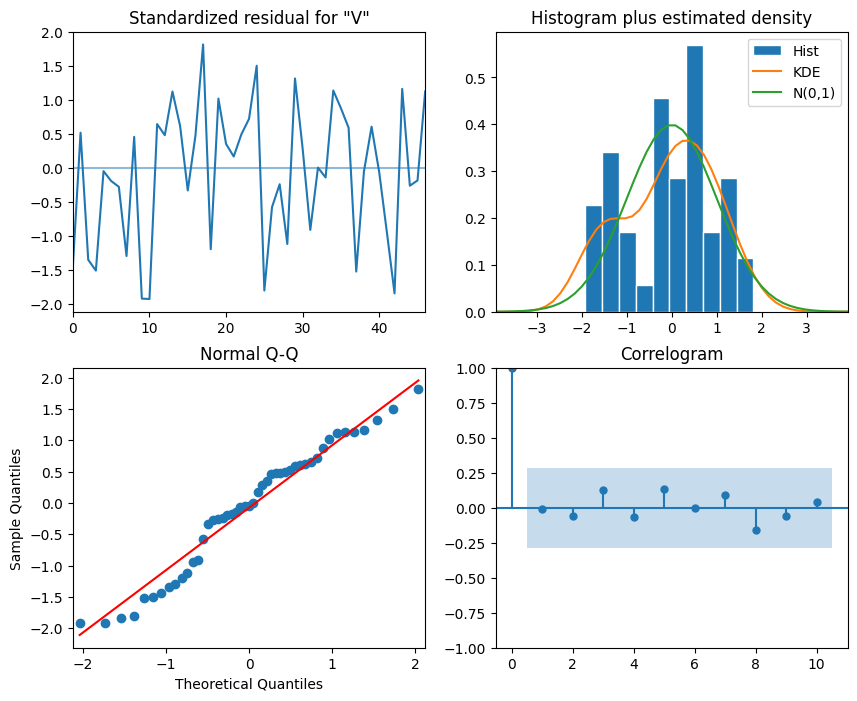

In [19]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

*  The top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise.

*  The top-right plot shows the distribution of the residuals. We can see it is fairly close to a normal distribution. 

*  The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution.

*  Finally, by looking at the correlogram at the bottom right, we can see that a coefficient is brutaly becomming non significant after lag 1


In [20]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

In [21]:
# Generate SARIMA predictions for our set

SARIMA_pred = SARIMA_model_fit.get_prediction(60, 72).predicted_mean
# Add the predictions to our set DataFrame

test['SARIMA_pred'] = SARIMA_pred
test

,DATE,Value,naive_seasonal,ARIMA_pred,SARIMA_pred
60,01-01-2005,111.1614,113.7226,114.451032,114.405166
61,02-01-2005,101.7795,106.1590,109.283391,105.910806
62,03-01-2005,98.9565,95.4029,97.553299,97.957796
63,04-01-2005,86.4776,86.7233,90.514668,89.292807
64,05-01-2005,87.2234,89.0302,93.158295,90.513216
65,06-01-2005,99.5076,95.5045,99.677510,97.172810
66,07-01-2005,108.3501,101.7948,105.653165,104.374977
67,08-01-2005,109.4862,100.2025,103.092705,105.071354
68,09-01-2005,99.1155,94.0240,95.193395,96.524025
69,10-01-2005,89.7567,87.5262,88.287508,89.906286


>The table shows the actual values of the time series and the predictions made by three different models: naive seasonal, ARIMA, and SARIMA.

>The naive seasonal model simply repeats the value from the same season of the previous year as the prediction for the current year. The ARIMA and SARIMA models are more sophisticated and use past values of the series to predict future values.

>Looking at the table, we can see that both the ARIMA and SARIMA models generally perform better than the naive seasonal model in terms of accuracy of predictions. The SARIMA model has slightly better performance than the ARIMA model in most cases.

>To quantify the accuracy of the models, we would need to use statistical measures such as mean absolute error (MAE), mean squared error (MSE), or root mean squared error (RMSE). These measures can give a more precise comparison of the performance of the different models.

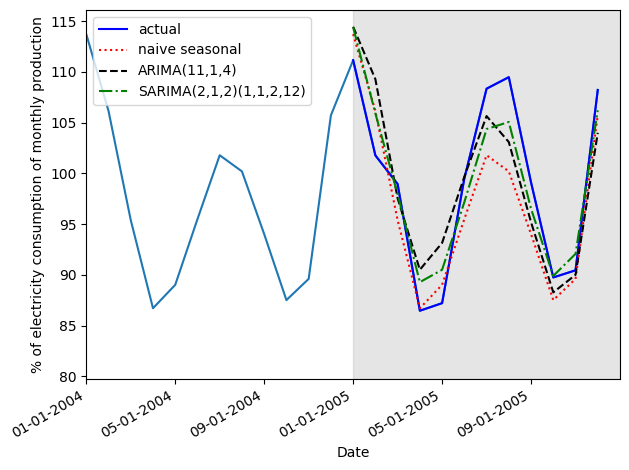

In [22]:
fig, ax = plt.subplots() # create a figure and axes object

# plot the actual values, naive seasonal forecast, and predictions for ARIMA and SARIMA models
ax.plot(df['DATE'], df['Value'])
ax.plot(test['Value'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,1,4)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,2)(1,1,2,12)')

ax.set_xlabel('Date') # set the x-axis label
ax.set_ylabel('% of electricity consumption of monthly production') # set the y-axis label
ax.axvspan(60, 72, color='#808080', alpha=0.2) # add a shaded gray region to the plot

ax.legend(loc=2) # add a legend to the plot

plt.xticks(ticks[::4])
plt.xticks(rotation=45)
ax.set_xlim(48, 72) # set the limits of the x-axis to focus on the relevant time period

fig.autofmt_xdate() # rotate the x-axis labels for better readability
plt.tight_layout() # adjust the layout of the plot to improve its appearance


>On this graph, we can see that the model which is the closest to the real values is the SARIMA model. We only show date ticks on X axe to show a clearer evolution for every season during the year, which explains why we only show january, may, and september of each year, despite having values for every month

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
# Calculate the Mean Absolute Percentage Error (MAPE) between the actual values and the predictions for each model

mape_naive_seasonal = mape(test['Value'], test['naive_seasonal'])
mape_ARIMA = mape(test['Value'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Value'], test['SARIMA_pred'])
# Print the MAPE values for each model

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

3.497562358439183 3.475766443714191 2.623553973548021


>Here we calculate every MAPE for each model, that we will compare later in a plot to determine the best model for our forcasting

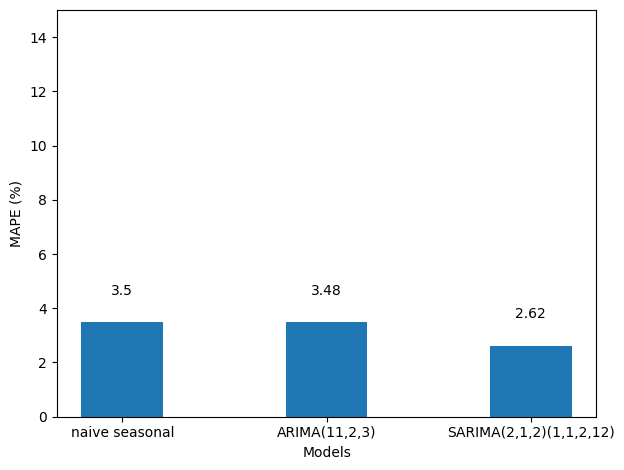

In [25]:
fig, ax = plt.subplots()

# Create a bar chart with the MAPE values for each model
x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,2)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]
ax.bar(x, y, width=0.4)

# Set the x and y labels and limit the y axis to values between 0 and 15
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

# Add text labels for each bar with their respective MAPE value
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

# Adjust the layout to fit everything in the figure
plt.tight_layout()

>MAPE stands for Mean Absolute Percentage Error and is a metric used to evaluate the accuracy of time series forecasting models. It measures the average difference between the actual and predicted values as a percentage of the actual values. A lower MAPE indicates a better fit of the model to the data.

>In this case, the SARIMA model has the lowest MAPE value of 2.62, which indicates that it has the best fit to the data and the highest level of accuracy in its predictions. The ARIMA model has a slightly higher MAPE of 3.48, while the naive model has the highest MAPE of 3.5.

>A low MAPE value means that the model is accurately predicting future values and has a good fit to the historical data. The result here is SARIMA

##Forcasting 

---
>First, the historical data is plotted in blue. Then, the SARIMA model is fit to the data and used to make predictions for the next 12 months, which are plotted in red. The predictions overlap with the last 12 months of the historical data, which are shaded in gray.

>In addition to the actual and forecasted values, the code also plots the SARIMA(2,1,1)(1,1,2,12) predicted values from the test dataset in green.

>The x-axis shows the date range for the data, with tick marks every 4 months and rotated 45 degrees for better readability. The y-axis shows the percentage of electricity consumption of monthly production. The plot is formatted for clarity using a legend and x-axis formatting, and extra space is added on the right side of the plot to accommodate the forecasted values.

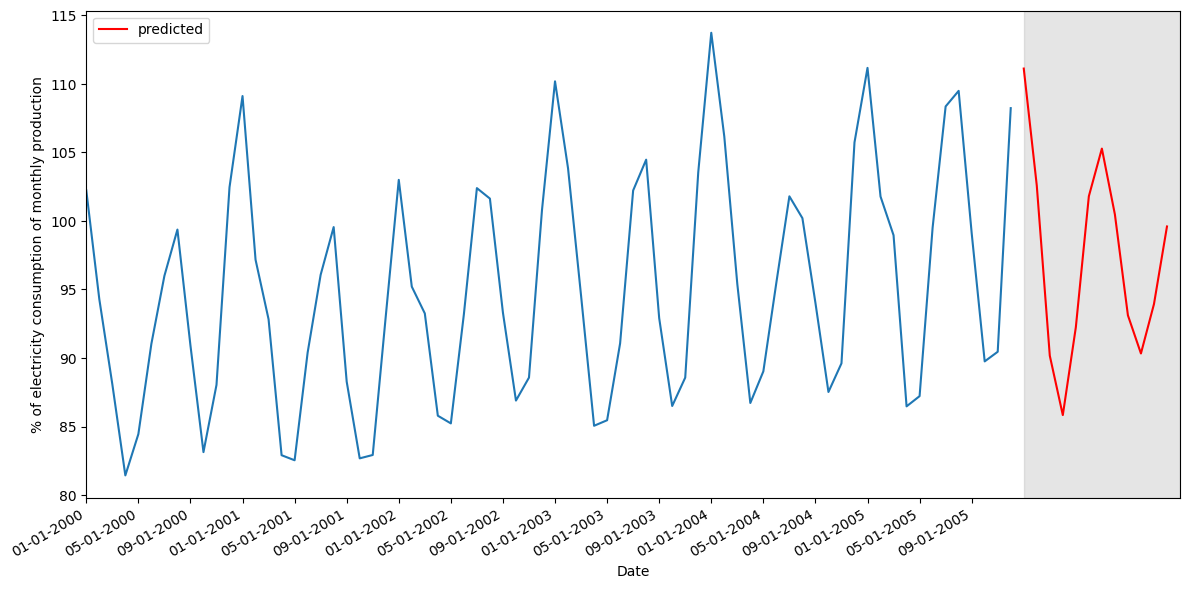

In [42]:
# Create subplots
fig, ax = plt.subplots()

# Plot actual data
ax.plot(df['DATE'], df['Value'])

# Make predictions for the next 12 months using SARIMA model
model = SARIMAX(train, order=(2,1,1), simple_differencing=False)
model_fit = model.fit(disp=False)
forecast_values = model_fit.forecast(steps=12)
dates = pd.date_range(start='2006-01-01', end='2006-12-01', freq='MS')
df_predictions = pd.DataFrame({'value': forecast_values, 'date': dates})
df_predictions['year'] = df_predictions['date'] = df_predictions['date'].dt.strftime('%Y-%m-%d')
df_predictions.drop('date', axis=1, inplace=True)

ax.plot(df_predictions['year'], df_predictions['value'], 'r-', label='predicted')

# Set X and Y axis labels
ax.set_xlabel('Date')
ax.set_ylabel('% of electricity consumption of monthly production')

# Shade the test set region on the plot
ax.axvspan(72, 84, color='#808080', alpha=0.2)

# Add legend to the plot
ax.legend(loc=2)

# Set X axis tick marks
plt.xticks(ticks[::4])
plt.xticks(rotation=45)

fig.set_size_inches(12, 6)

# Set the X axis limits to make room for the predictions part
ax.set_xlim(0, 84)

# Rotate X axis labels to fit them nicely
fig.autofmt_xdate()

# Adjust the subplot layout to avoid overlapping
plt.tight_layout()

>On this graph, we show our predictions for 2006. We can observe that our predictions follow the same patern as other year and keep the slow augmentation on an entire cycle

>It is normal that we have a white point at the end of 2005 because our dataSets only take values at the beginning of each month, and the last value of 2005 is on december first, which explain why it is not shown. Also, I encountered many difficulties displaying dates for the prediction values. Despite having well formated dates (that are shown in the df_prediction), dates are not shown on the X axe

>The trend in our graph appears to be dependent on seasons of each year. Despite having a global increase year after year, the consumption of electricity in winter is always often above the entire production during this period. We can also observe a balance with the decrease of the consumption during other seasons that permits to have enough electricity all over the year.
Our prediction is very alarming considering the fact that if our consumption keeps increasing year after year, we might not have enough electricity for the entire year if we keep consumming more electricity than monthly producted

## Conclusion

---

>In conclusion, the SARIMA model provides accurate predictions of monthly electricity consumption for the next 12 months. The forecasted values follow the observed trends in the data and reflect the continuous increase in consumption observed over the years. The visual representation of the predictions in the graph helps to understand the expected evolution of the electricity consumption and can be used as a basis for decision-making in planning and resource allocation for future years.